In [1]:
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from PIL import Image
import torch
from pytorch3d.renderer import FoVPerspectiveCameras, look_at_view_transform
import torchvision.transforms as transforms
from file_util import load_frame_obj
from pathlib import Path

to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

/home/jorge/miniconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from file_util import OBJAnimation

device = torch.device("cuda:0")

animation = OBJAnimation(Path('../data/dancing'))
mesh = animation.load_frame(1)

/home/jorge/miniconda3/envs/thesis/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [3]:
R, T = look_at_view_transform(dist=2, azim=0, elev=0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60)

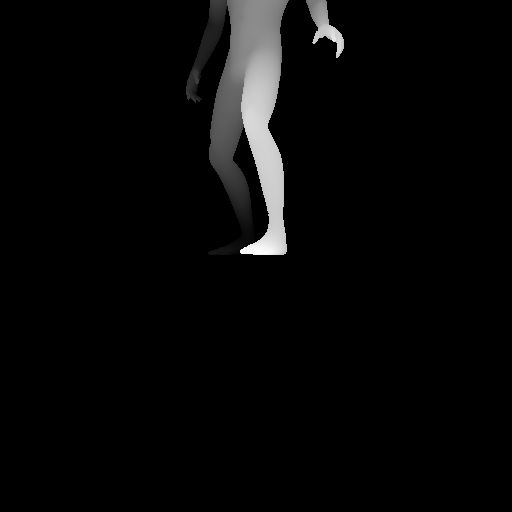

In [4]:
from rendering import process_depth_map, rasterize

res = 512
fragments, depth_map = rasterize(cameras, mesh, res)

depth_map_normalized = process_depth_map(depth_map).to(device)
depth_img = to_pil(depth_map_normalized)

depth_img

In [89]:
from diffusion import depth2img_pipe, depth2img

pipe = depth2img_pipe()

Couldn't connect to the Hub: 401 Client Error. (Request ID: Root=1-66d76bbb-765e83120467aa4755a7c545;2d5a9aeb-8d38-469b-adfd-e6999d2afca3)

Repository Not Found for url: https://huggingface.co/api/models/runwayml/stable-diffusion-v1-5.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.
Invalid username or password..
Will try to load from local cache.
Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]/home/jorge/miniconda3/envs/thesis/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:01<

In [90]:
img_out = depth2img(pipe, 'Deadpool Dancing', depth_img)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:05<00:00,  5.83it/s]


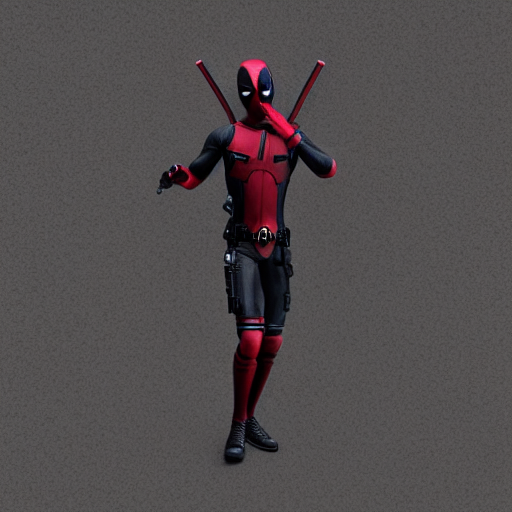

In [91]:
feature_tensor = to_tensor(img_out).to(device).permute(1,2,0)
img_out

In [92]:
from util import project_feature_map_to_vertices

vertex_features = project_feature_map_to_vertices(
    mesh,
    cameras,
    depth_map,
    feature_tensor
)

# face_vert_features = mesh.faces_list()[0]
face_vert_features = vertex_features[mesh.faces_list()[0]]

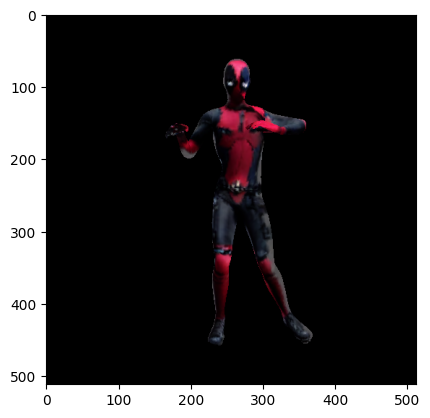

In [93]:
from rendering import rasterize_vertex_features

reposed = load_frame_obj(Path('../data/dancing'), frame=10, device=device)
pixel_features = rasterize_vertex_features(cameras, reposed, res, vertex_features)

plt.imshow(pixel_features.cpu())

In [94]:
for frame in range(77):
    pass

reposed = load_frame_obj(Path('../data/dancing'), frame=10, device=device)
pixel_features = rasterize_vertex_features(cameras, reposed, res, vertex_features)

KeyboardInterrupt: 

In [104]:
from tqdm import tqdm

frames = []
for frame in tqdm(animation.framenums()):
    posed = load_frame_obj(Path('../data/dancing'), frame=frame, device=device)
    pixel_features = rasterize_vertex_features(cameras, posed, res, vertex_features)
    frames.append(pixel_features)

  0%|          | 0/77 [00:00<?, ?it/s]/home/jorge/miniconda3/envs/thesis/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
100%|██████████| 77/77 [00:18<00:00,  4.21it/s]


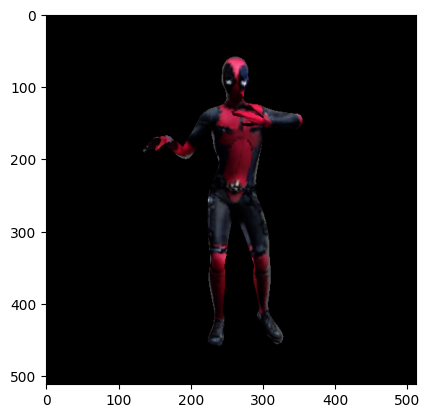

In [105]:
plt.imshow(frames[6].cpu())

In [106]:
import imageio

with imageio.get_writer(Path('../outs/deadpool.gif'), mode='I') as writer:
    for frame in frames:
        frame_pil = to_pil(frame.permute(2, 0, 1))
        writer.append_data(frame_pil)

In [6]:
import rerun as rr
import rerun_util as ru

rr.init('debug', spawn=True)
rr.log('/', rr.ViewCoordinates.LUF, static=True)
rr.log('/', rr.Transform3D())

rr.log('cam', ru.pt3d_FovCamera(cameras, 0, res=res))
cam_trans = cameras.get_world_to_view_transform().inverse()
rr.log('cam', ru.pt3d_transform(cam_trans))
rr.log('cam', rr.Image(depth_map.cpu().numpy()))

# log mesh
rr.log("mesh", ru.pt3d_mesh(mesh, vertex_colors=vertex_colors))


[2024-09-05T11:07:48Z INFO  re_sdk_comms::server] Hosting a SDK server over TCP at 0.0.0.0:9876. Connect with the Rerun logging SDK.
[2024-09-05T11:07:48Z INFO  re_sdk_comms::server] New SDK client connected from: 127.0.0.1:55494


NameError: name 'vertex_colors' is not defined

[2024-09-05T11:07:48Z INFO  winit::platform_impl::platform::x11::window] Guessed window scale factor: 1
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
[2024-09-05T11:07:52Z INFO  egui_wgpu] There were 3 available wgpu adapters: {backend: Vulkan, device_type: DiscreteGpu, name: "NVIDIA GeForce RTX 4070 Ti SUPER", driver: "NVIDIA", driver_info: "550.90.07", vendor: 0x10DE, device: 0x2705}, {backend: Vulkan, device_type: Cpu, name: "llvmpipe (LLVM 15.0.7, 256 bits)", driver: "llvmpipe", driver_info: "Mesa 23.2.1-1ubuntu3.1~22.04.2 (LLVM 15.0.7)", vendor: 0x10005}, {backend: Gl, device_type: Cpu, name: "llvmpipe (LLVM 15.0.7, 256 bits)", driver: "OpenGL", driver_info: "4.5 (Compatibility Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2", vendor: 0x10005}
[2024-09-05T11:07:53Z WARN  re_renderer::context] Bad software rasterizer detected - expect poor performance and crashes. See: https://www.rerun.io/docs/getting-started/troubleshooting#graphics-issues